<a href="https://colab.research.google.com/github/Vedant2100/w26/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q1. Setup andf MNIST models with diff k and p

 Normalization using train data mean and train data standard dev to both training and test data.

In [1]:
from datasets import load_dataset
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

dataset = load_dataset("ylecun/mnist")

def format_data(split, mean=None, std=None):
    images = np.array([np.array(img).flatten() for img in split["image"]])
    if mean is None or std is None:
        mean = np.mean(images, axis=0)
        std = np.std(images, axis=0)
    std_copy = std.copy()
    std_copy[std_copy == 0] = 1.0
    X = (images - mean) / std_copy
    y = np.array(split["label"])
    return X, y, mean, std

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


In [2]:
X_train, y_train, train_mean, train_std = format_data(dataset["train"])
X_test, y_test, _, _ = format_data(dataset["test"], train_mean, train_std)
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of y_train: (60000,)
Shape of y_test: (10000,)


In [3]:
np.random.seed(0)
idxs = []
for c in range(10):
    class_idxs = np.where(y_train == c)[0]
    chosen = np.random.choice(class_idxs, size=1000, replace=True)
    idxs.append(chosen)
idxs = np.concatenate(idxs)
np.random.shuffle(idxs)
X_train = X_train[idxs]
y_train = y_train[idxs]

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class shallowNN(nn.Module):
    def __init__(self, k = 1, p = 0.1):
        super(shallowNN, self).__init__()
        self.fc1 = nn.Linear(784, k)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        self.dropout = nn.Dropout(1-p) # keep probabilities are provided
        self.fc2 = nn.Linear(k, 10)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc2.bias)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = shallowNN()

In [5]:
import matplotlib.pyplot as plt
import tqdm


def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs = 80, lr = 0.001):
    model = shallowNN(k=k, p=p)
    model.apply(init_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    train_acc = {}
    test_acc = {}
    loss_hist = {}
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        inputs = torch.tensor(X_train, dtype=torch.float32)
        labels = torch.tensor(y_train, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss_hist[(k, p, epoch)] = loss.item()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            model.eval()
            train_acc[(k, p, epoch)] = (model(inputs).argmax(dim=1) == labels).float().mean().item()
            test_outputs = model(torch.tensor(X_test, dtype=torch.float32))
            test_acc[(k, p, epoch)] = (test_outputs.argmax(dim=1) == torch.tensor(y_test, dtype=torch.long)).float().mean().item()
            model.train()
    return train_acc, test_acc, loss_hist

## 2.1 No dropout (p = 1.0 and dropout probability = 0.0)
With p = 1.0, as k (the number of units )increases, the training accuracy and test accuracy both improve up until k = 15 , where it has the best results, and then dropping when we get to k = 35. At no k in the current set, the training accuracy has become 100% but I tried increasing the learning rate as well as the no of epochs, and with lr = 0.01 and 500 epochs, k = 35 achieved 100% training accuracy and k = 15 very close by at 99.96%.

### LR = 0.001 (default)

100%|██████████| 80/80 [00:04<00:00, 16.18it/s]


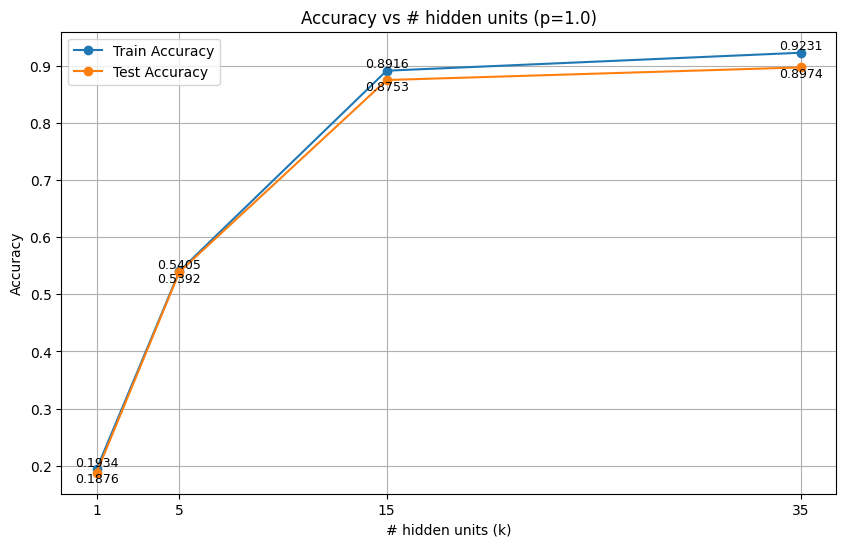

In [6]:
torch.manual_seed(0)
kvals = [1, 5, 15, 35]
pvals = [1.0]
lr = 0.001
epochs = 80
for p in pvals:
    overall_train_acc = {}
    overall_test_acc = {}
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)
    plt.figure(figsize=(10, 6))
    plt.xticks(kvals)
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Train Accuracy')
    plt.plot(kvals, [overall_test_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Test Accuracy')
    plt.xlabel('# hidden units (k)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs # hidden units (p={p})')
    plt.legend()
    plt.grid()
    train_values = [overall_train_acc[(kv, p, epochs-1)] for kv in kvals]
    test_values = [overall_test_acc[(kv, p, epochs-1)] for kv in kvals]
    for i, kv in enumerate(kvals):
        plt.text(kv, train_values[i], f'{train_values[i]:.4f}', ha='center', va='bottom', fontsize=9)
        plt.text(kv, test_values[i], f'{test_values[i]:.4f}', ha='center', va='top', fontsize=9)
    plt.show()


### LR = 0.01

100%|██████████| 80/80 [00:04<00:00, 16.87it/s]


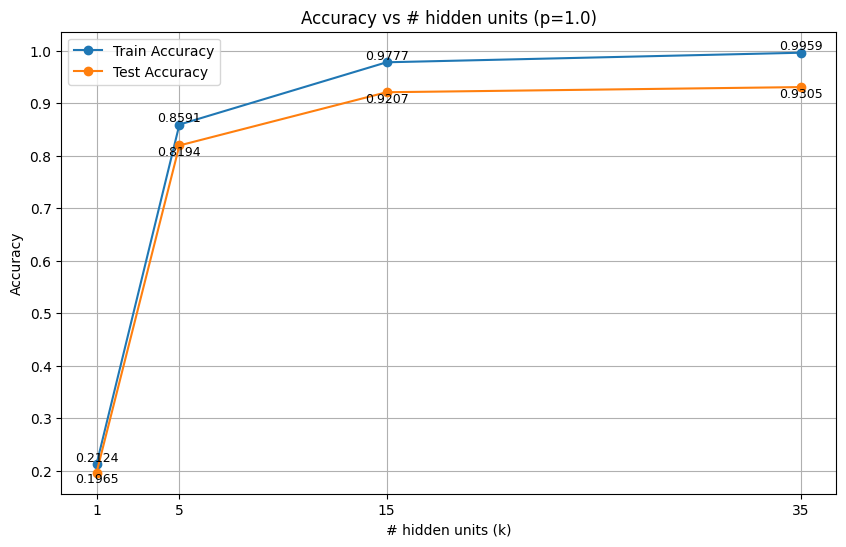

In [7]:
torch.manual_seed(0)
kvals = [1, 5, 15, 35]
pvals = [1.0]
epochs = 80
lr = 0.01
for p in pvals:
    overall_train_acc = {}
    overall_test_acc = {}
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)
    plt.figure(figsize=(10, 6))
    plt.xticks(kvals)
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Train Accuracy')
    plt.plot(kvals, [overall_test_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Test Accuracy')
    plt.xlabel('# hidden units (k)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs # hidden units (p={p})')
    plt.legend()
    plt.grid()
    train_values = [overall_train_acc[(kv, p, epochs-1)] for kv in kvals]
    test_values = [overall_test_acc[(kv, p, epochs-1)] for kv in kvals]
    for i, kv in enumerate(kvals):
        plt.text(kv, train_values[i], f'{train_values[i]:.4f}', ha='center', va='bottom', fontsize=9)
        plt.text(kv, test_values[i], f'{test_values[i]:.4f}', ha='center', va='top', fontsize=9)
    plt.show()


100%|██████████| 500/500 [00:31<00:00, 16.07it/s]


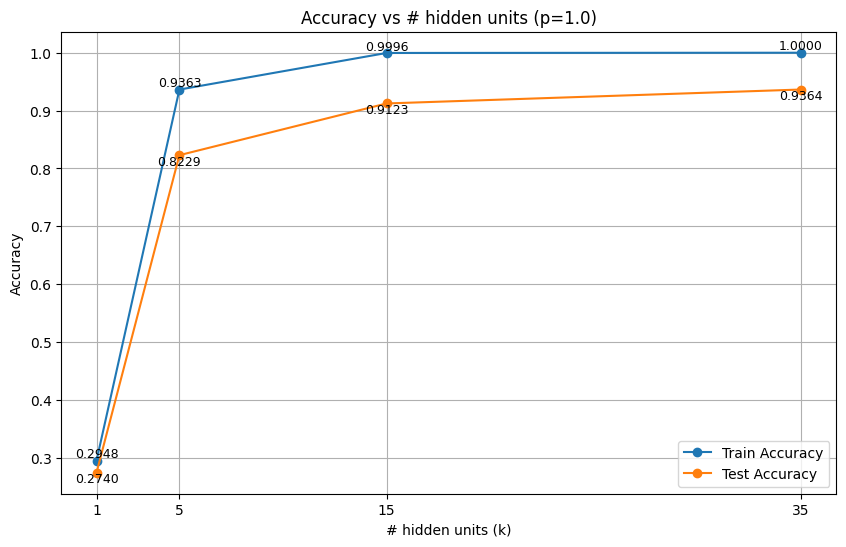

In [8]:
torch.manual_seed(0)
kvals = [1, 5, 15, 35]
pvals = [1.0]
epochs = 500
lr = 0.01
for p in pvals:
    overall_train_acc = {}
    overall_test_acc = {}
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)
    plt.figure(figsize=(10, 6))
    plt.xticks(kvals)
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Train Accuracy')
    plt.plot(kvals, [overall_test_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Test Accuracy')
    plt.xlabel('# hidden units (k)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs # hidden units (p={p})')
    plt.legend()
    plt.grid()
    train_values = [overall_train_acc[(kv, p, epochs-1)] for kv in kvals]
    test_values = [overall_test_acc[(kv, p, epochs-1)] for kv in kvals]
    for i, kv in enumerate(kvals):
        plt.text(kv, train_values[i], f'{train_values[i]:.4f}', ha='center', va='bottom', fontsize=9)
        plt.text(kv, test_values[i], f'{test_values[i]:.4f}', ha='center', va='top', fontsize=9)
    plt.show()


## 2.2

1. Generally the training accuracy has incerased with increasing p which makes sense as the more neurons are randomly deactivated, the network's capacity to learning data lessens. It dropped a lot in p = 1.0 case where in all neurons were deactivated, then the model didnt learn anything.

2. When p is smaller its generally more difficult to optimize than when p is higher because less number of gradients have to be calculated and backpropagated in this case than higher p.

100%|██████████| 80/80 [00:04<00:00, 16.41it/s]


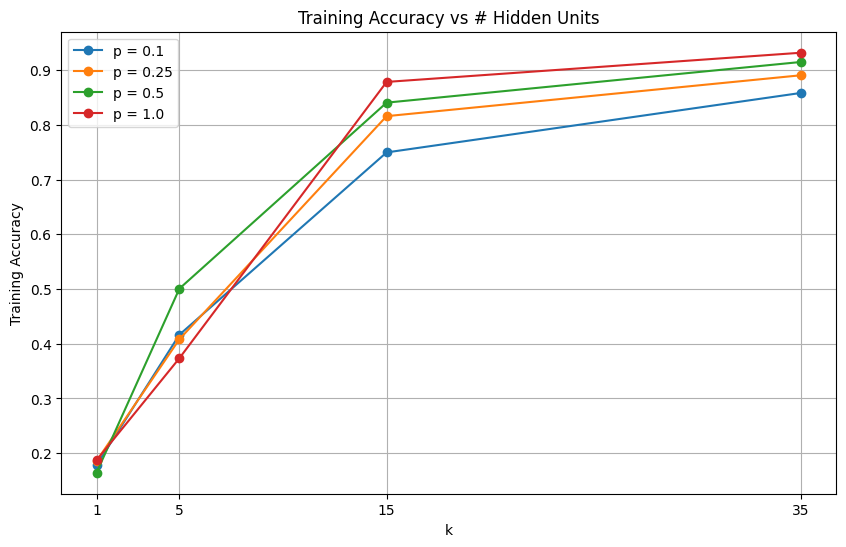

In [9]:
kvals = [1, 5, 15, 35]
pvals = [0.1, 0.25, 0.5, 1.0]
epochs = 80
lr = 0.001
torch.manual_seed(0)
overall_train_acc = {}
overall_test_acc = {}
for p in pvals:
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)
plt.figure(figsize=(10, 6))
for p in pvals:
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o',label=f"p = {p}")
plt.xticks(kvals)
plt.xlabel('k')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs # Hidden Units')
plt.legend()
plt.grid()
plt.show()


Currently, none of the networks have reached training accuracy exactly 100% though k = 35, p = 0.1 is very close. In order to determine at what min k among given values will it be achieved, I have to increase the number of epochs.

## 2.2

3. For all values of p (except P = 1.0), a training accuracy of 100% is achieved at k = 35, given sufficient epochs to train.
For p = 1.0, a 100% accuracy will never be achieved as the model won't ever be able to learn the training data.

100%|██████████| 300/300 [00:18<00:00, 16.31it/s]


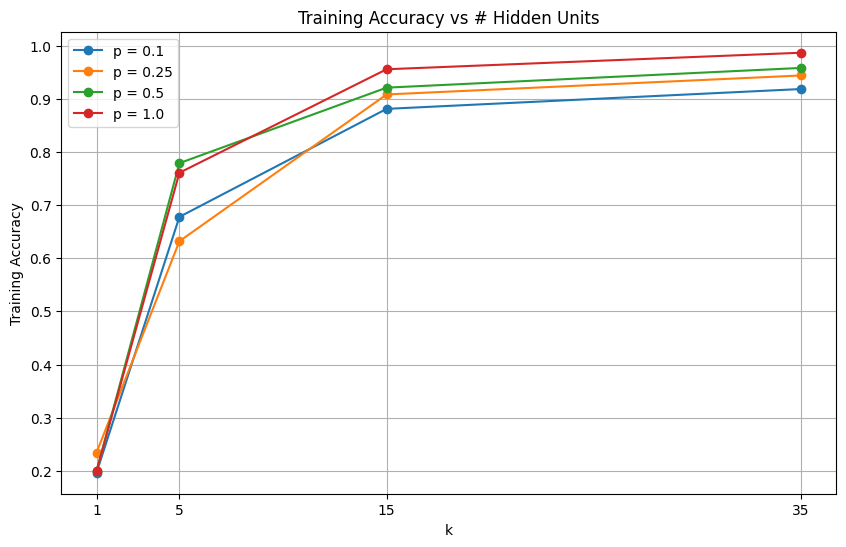

In [10]:
kvals = [1, 5, 15, 35]
pvals = [0.1, 0.25, 0.5, 1.0]
epochs = 300
lr = 0.001
torch.manual_seed(0)
overall_train_acc = {}
overall_test_acc = {}
for p in pvals:
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)

plt.figure(figsize=(10, 6))

for p in pvals:
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o',label=f"p = {p}")
plt.xticks(kvals)
plt.xlabel('k')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs # Hidden Units')
plt.annotate
plt.legend()
plt.grid()
plt.show()


## 2.3

1. Yes, generally higher the dropout (1-p) or lower the p, the test accuracy is higher (except in the case of p = 0) , it makes sense because the model is more generalizable with more dropout.

2. For k = 35, and p = 0.0, i get highest test accuracy (i.e. no dropout case)

In [11]:
kvals = [1, 5, 15, 35]
pvals = [0.1, 0.25, 0.5, 1.0]
epochs = 80
lr = 0.001
torch.manual_seed(0)
overall_train_acc = {}
overall_test_acc = {}
for p in pvals:
    for k in kvals:
         train_acc, tesat_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)

plt.figure(figsize=(10, 6))

for p in pvals:
    plt.plot(kvals, [overall_test_acc[(k, p, epochs-1)] for k in kvals], marker='o',label=f"p = {p}")
plt.xticks(kvals)
plt.xlabel('k')
plt.ylabel('Test Accuracy')
plt.title('Trest Accuracy vs # Hidden Units')
plt.legend()
plt.grid()
plt.show()


100%|██████████| 80/80 [00:05<00:00, 15.30it/s]


KeyError: (1, 0.1, 79)

<Figure size 1000x600 with 0 Axes>

## Q3

In [ ]:
np.random.seed(0)
possible_labels = list(range(0, 10))
flipped_example_index = np.random.choice(range(len(X_train)), size=4500, replace=False)
for i in flipped_example_index:
    original_label = y_train[i]
    other_labels = [l for l in possible_labels if l != original_label]
    y_train[i] = np.random.choice(other_labels, replace = True)

print(f"No of y_train flipped: {len(flipped_example_index)}")

## 3.1 No dropout p = 0.0
Even this time, as k increase the training accuracy improves. But at no k, within 80 epochs, does the trianing accuracy becomes 100%.

In [ ]:
torch.manual_seed(0)
kvals = [1, 5, 15, 35]
pvals = [0.0]
lr = 0.001
epochs = 80
for p in pvals:
    overall_train_acc = {}
    overall_test_acc = {}
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)
    plt.figure(figsize=(10, 6))
    plt.xticks(kvals)
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Train Accuracy')
    plt.plot(kvals, [overall_test_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Test Accuracy')
    plt.xlabel('# hidden units (k)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs # hidden units (p={p})')
    plt.legend()
    plt.grid()
    train_values = [overall_train_acc[(kv, p, epochs-1)] for kv in kvals]
    test_values = [overall_test_acc[(kv, p, epochs-1)] for kv in kvals]
    for i, kv in enumerate(kvals):
        plt.text(kv, train_values[i], f'{train_values[i]:.4f}', ha='center', va='bottom', fontsize=9)
        plt.text(kv, test_values[i], f'{test_values[i]:.4f}', ha='center', va='top', fontsize=9)
    plt.show()


In [ ]:
torch.manual_seed(0)
kvals = [1, 5, 15, 35]
pvals = [0.0]
lr = 0.001
epochs = 500
for p in pvals:
    overall_train_acc = {}
    overall_test_acc = {}
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)
    plt.figure(figsize=(10, 6))
    plt.xticks(kvals)
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Train Accuracy')
    plt.plot(kvals, [overall_test_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Test Accuracy')
    plt.xlabel('# hidden units (k)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs # hidden units (p={p})')
    plt.legend()
    plt.grid()
    train_values = [overall_train_acc[(kv, p, epochs-1)] for kv in kvals]
    test_values = [overall_test_acc[(kv, p, epochs-1)] for kv in kvals]
    for i, kv in enumerate(kvals):
        plt.text(kv, train_values[i], f'{train_values[i]:.4f}', ha='center', va='bottom', fontsize=9)
        plt.text(kv, test_values[i], f'{test_values[i]:.4f}', ha='center', va='top', fontsize=9)
    plt.show()


## 3.2
Similarly as before, higher the dropout rate (p) the trianing accuracy is equal or lwoer at every k (specially at p = 1.0). Also, iots easier to optimize when p is higher as less calculations are involved.

However at no k, within 80 epochs, does the training accuracy become 100% in this noisy dataset. Its max 60%.

In [ ]:
kvals = [1, 5, 15, 35]
pvals = [0.1, 0.25, 0.5, 1.0]
epochs = 80
lr = 0.001
torch.manual_seed(0)
overall_train_acc = {}
overall_test_acc = {}
for p in pvals:
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)
plt.figure(figsize=(10, 6))
for p in pvals:
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o',label=f"p = {p}")
plt.xticks(kvals)
plt.xlabel('k')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs # Hidden Units')
plt.legend()
plt.grid()
plt.show()

### 3.3

In [ ]:
kvals = [1, 5, 15, 35]
pvals = [0.1, 0.25, 0.5, 1.0]
epochs = 80
lr = 0.001
torch.manual_seed(0)
overall_train_acc = {}
overall_test_acc = {}
for p in pvals:
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)
plt.figure(figsize=(10, 6))
for p in pvals:
    y_vals = [overall_test_acc[(kv, p, epochs-1)] for kv in kvals]
    plt.plot(kvals, y_vals, marker='o', label=f"p = {p}")
    for i, kv in enumerate(kvals):
        plt.text(kv, y_vals[i], f'{y_vals[i]:.2f}', fontsize=8, ha='center', va='bottom')
plt.xticks(kvals)
plt.xlabel('k')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs # Hidden Units')
plt.legend()
plt.grid()
plt.show()


## Q4